## Accessing NOAA C-CAP Regional Land Cover with the Planetary Computer STAC API

The [National Oceanic and Atmospheric Administration (NOAA) Coastal Change Analysis Program (C-CAP) Regional Land Cover](https://coast.noaa.gov/digitalcoast/data/ccapregional.html) dataset features standardized raster based land cover for coastal areas of the contiguous United States (CONUS) and Hawaii at a 30-meter resolution available from 1975 through 2016.  The data are derived from Landsat's Thematic Mapper (TM) satellite imagery and ancillary information.

The use of standardized data and procedures assures consistency through time and across geographies. C-CAP data forms the coastal expression of the National Land Cover Database (NLCD) and the A-16 land cover theme of the National Spatial Data Infrastructure (NSDI). 

In this notebook, we'll demonstrate how to access and work with this data through the Planetary Computer. Documentation for this dataset is available at the [Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/dataset/noaa-c-cap).

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

In [1]:
from matplotlib.colors import ListedColormap
from pystac.extensions.item_assets import ItemAssetsExtension

import numpy as np
import odc.stac
import planetary_computer
import pystac_client
import rasterio
import rasterio.features
import rich.table

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Query for available data

The NOAA C-CAP dataset reaches back to 1975 in select areas. We selected the coordinates for Lansing, MI to showcase data for 1975 and use the STAC API to find what data items are available.

In [3]:
# Select area and time of interest
latitude = 42.7325
longitude = -84.5555
location = [longitude, latitude]
geometry = {
    "type": "Point",
    "coordinates": location,
}
datetimes = [
    "1975",
]

buffer = 2
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]
items = dict()
search = catalog.search(collections="noaa-c-cap", intersects=geometry, datetime="1975")
item = next(search.items())

### Available Assets

Let's display the available assets for the NOAA C-CAP item. 

In [4]:
t = rich.table.Table("Key", "Title")
for key, asset in item.assets.items():
    t.add_row(key, asset.title)
t

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key              ┃ Title                           ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data             │                                 │
│ tilejson         │ TileJSON with default rendering │
│ rendered_preview │ Rendered preview                │
└──────────────────┴─────────────────────────────────┘

### Loading the land cover data

For this example, we'll visualize the land cover classifications surrounding Lansing, MI. Let's grab the data COG and load them into an xarray using [odc-stac](https://github.com/opendatacube/odc-stac). 


In [5]:
data = odc.stac.load(
    [item],
    crs="EPSG:5070",
    bbox=bbox,
    bands="data",
    resolution=30,
)
data

<xarray.Dataset>
Dimensions:      (y: 16091, x: 12565, time: 1)
Coordinates:
  * y            (y) float64 2.491e+06 2.491e+06 ... 2.008e+06 2.008e+06
  * x            (x) float64 7.454e+05 7.455e+05 ... 1.122e+06 1.122e+06
    spatial_ref  int32 5070
  * time         (time) datetime64[ns] 1975-01-01
Data variables:
    data         (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

### Displaying the data

Let's use the classification colors as defined in the [C-CAP Classification Scheme and Class Definitions](https://coast.noaa.gov/data/digitalcoast/pdf/ccap-class-scheme-regional.pdf) document. The classification colors are also defined in a colormap contained in the source GeoTIFF image. We'll extract the colormap from the GeoTIFF image and apply it to the plot.

In [6]:
# Extract colormap from GeoTIFF
collection = catalog.get_collection("noaa-c-cap")
ia = ItemAssetsExtension.ext(collection)
x = ia.item_assets["data"]

class_names = {
    x["description"]: x["value"] for x in x.properties["classification:classes"]
}
values_to_classes = {v: k for k, v in class_names.items()}
class_count = len(class_names)
class_names

{'Background': 0,
 'Unclassified (Cloud, Shadow, etc)': 1,
 'High Intensity Developed': 2,
 'Medium Intensity Developed': 3,
 'Low Intensity Developed': 4,
 'Developed Open Space': 5,
 'Cultivated Crops': 6,
 'Pasture/Hay': 7,
 'Grassland/Herbaceous': 8,
 'Deciduous Forest': 9,
 'Evergreen Forest': 10,
 'Mixed Forest': 11,
 'Scrub/Shrub': 12,
 'Palustrine Forested Wetland': 13,
 'Palustrine Scrub/Shrub Wetland': 14,
 'Palustrine Emergent Wetland (Persistent)': 15,
 'Estuarine Forested Wetland': 16,
 'Estuarine Scrub/Shrub Wetland': 17,
 'Estuarine Emergent Wetland': 18,
 'Unconsolidated Shore': 19,
 'Bare Land': 20,
 'Open Water': 21,
 'Palustrine Aquatic Bed': 22,
 'Estuarine Aquatic Bed': 23,
 'Tundra': 24,
 'Perennial Ice/Snow': 25}

In [7]:
# Define colormap from STAC data
with rasterio.open(item.assets["data"].href) as src:
    colormap_def = src.colormap(1)  # get metadata colormap for band 1
    colormap = [
        np.array(colormap_def[i]) / 255 for i in range(len(colormap_def))
    ]  # transform to matplotlib color format

cmap = ListedColormap(colormap)

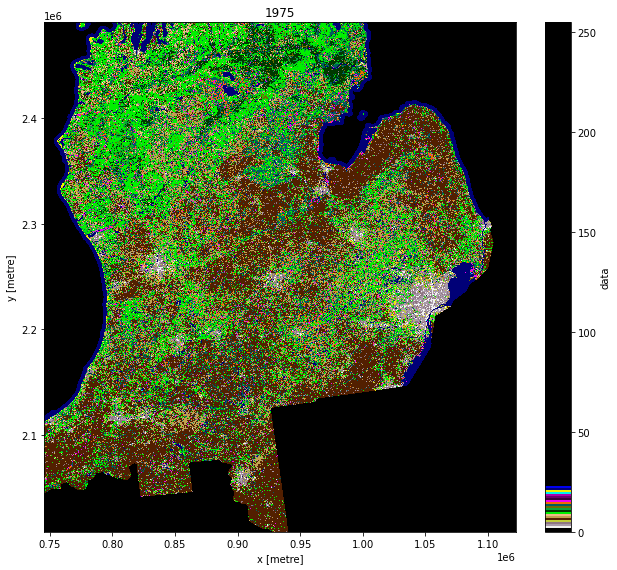

In [8]:
# Visualization
g = data["data"].plot.imshow(
    cmap=cmap,
    col="time",
    vmin=0,
    vmax=(len(colormap_def) - 1),
    col_wrap=1,
    size=8,
)
datetimes = data["data"].time.to_pandas().dt.strftime("%Y")

for ax, datetime in zip(g.axes.flat, datetimes):
    ax.set_title(datetime)

Rendering notes:
1. The `vmin` and `vmax` values are set to match the number of classes defined in the colormap in the source GeoTIFF image. Even though there are only 26 classes defined in the [C-CAP Classification Scheme and Class Definitions](https://coast.noaa.gov/data/digitalcoast/pdf/ccap-class-scheme-regional.pdf) document, the GeoTIFF produces 256 class values and corresponding colors. 